In [2]:
import matplotlib.pyplot as plt

import pandas as pd
from decipher.datasets.decipher_data import Decipher
import numpy as np
# from decipher.plots.heatmap import SplitHeatmap
# from decipher.library.reactome_heatmap import cluster_order


In [3]:
decipher = Decipher()


In [4]:
sl_across_file = "~/kornhill/work-vault/2-Projects/decipher/decipher-dvc/data/2_scores/functions-221115/NEST/functions-by-synthetic-essential-gene-partners.csv"
sl_across = pd.read_csv(sl_across_file)

sl_across = sl_across.loc[
    (sl_across["stringency"] == "lenient")
    & (sl_across["subset"] == "complete")
    & (sl_across["condition"].isin(decipher.cell_lines + list(decipher.combo_map)))
    & (sl_across["fdr"] < 0.3)
    & (sl_across["ess-binom-fdr"] < 0.3)
]


In [5]:
context_map = {
    "A549": "nsclc",
    "A427": "nsclc",
    "MDAMB231": "brca",
    "MCF7": "brca",
    "MCF10A": "brca",
    "CAL33": "hnsc",
    "CAL27": "hnsc",
    "nsclc": "nsclc",
    "brca": "brca",
    "hnsc": "hnsc",
    "pan-cancer": "pan-cancer",
}

sl_across["condition"] = sl_across["condition"].map(context_map)


In [7]:
heatmap = []
for (system, gene), df in sl_across.groupby(["name", "induced_by"]):
    conditions = df["condition"].values[0]
    if len(df) > 1:
        conditions = df["condition"].unique()
        if "pan-cancer" in conditions:
            condition = "pan-cancer"
        else:
            condition = conditions[0]

    heatmap.append([system, gene, condition])

heatmap = pd.DataFrame(heatmap, columns=["system", "gene", "condition"])
heatmap = heatmap.pivot(index="system", columns="gene", values="condition").fillna("None")


In [23]:
from matplotlib import gridspec
from matplotlib.ticker import FixedLocator
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list
import matplotlib as mpl

def get_cmap_from_classes_map(classes_map):
    tissue_colors = {
        "pan-cancer": "#bf616a",
        "nsclc": "#d08770",
        "brca": "#81a1c1",
        "hnsc": "#8fbcbb",
    }

    colors = [
        tissue_colors.get(i, "#FFFFFF")
        for i, _ in sorted(classes_map.items(), key=lambda x: x[1])
    ]
    cmap = ListedColormap(colors)

    return cmap


def map_classes_to_integer(dataframe):
    classes = np.unique(dataframe.values.ravel())
    classes_map = {_class: ind for ind, _class in enumerate(classes)}

    return dataframe.applymap(classes_map.get), classes_map


def cluster_order(data, **linkage_kwargs):
    """Cluster the rows"""

    Z = linkage(data, **linkage_kwargs)
    Z_ordered = optimal_leaf_ordering(Z, data)
    row_index = leaves_list(Z_ordered)

    Z = linkage(data.T, **linkage_kwargs)
    Z_ordered = optimal_leaf_ordering(Z, data.T)
    col_index = leaves_list(Z_ordered)

    return row_index, col_index

class SplitHeatmap(object):
    def __init__(
        self,
        dataframe,
        row_indices=None,
        col_indices=None,
        horizontal_gap=0,
        vertical_gap=0,
        cmap=None,
        norm=None,
    ):

        self.dataframe = dataframe
        self.row_indices = row_indices
        self.col_indices = col_indices

        if row_indices is None:
            self.row_indices = [np.arange(self.dataframe.shape[0])]

        if col_indices is None:
            self.col_indices = [np.arange(self.dataframe.shape[1])]

        self.vertical_gap = vertical_gap
        self.horizontal_gap = horizontal_gap

        self.cmap = cmap
        if self.cmap is None:
            self.cmap = mpl.colormaps["viridis"]

        self.norm = norm

    def _get_cmap_and_norm(self, i, j):
        try:
            cmap = self.cmap[i, j]
        except TypeError:
            cmap = self.cmap

        try:
            norm = self.norm[i, j]
        except TypeError:
            norm = self.norm

        return cmap, norm

    def convert_to_rgb(self):
        """Convert data to RGB

        TODO: consider remove this function?

        I'm having second thoughts about this function. This is only useful if you
        need to modify the data prior to transformation in ways that `plt.imshow`
        doesnt support. Betwen `norm` and `cmap`, I think you can do most transformations
        you need for the heatmap.
        """
        heatmap = []
        for i, row_index in enumerate(self.row_indices):
            inner_heatmap = []
            for j, col_index in enumerate(self.col_indices):
                df = self.dataframe.iloc[row_index, col_index].values

                cmap, norm = self._get_cmap_and_norm(i, j)

                _df = norm(df) if norm is not None else df
                rgb = cmap(_df)
                inner_heatmap.append(rgb)

            heatmap.append(inner_heatmap)

        self.heatmap = heatmap

        return self

    def plot(self, gap=0.1, fig_width=5):  # fraction of width
        fig_ratio = self.dataframe.shape[0] / self.dataframe.shape[1]
        self.fig = plt.figure(figsize=(fig_width, fig_width * fig_ratio))
        gs = gridspec.GridSpec(
            len(self.row_indices),
            len(self.col_indices),
            height_ratios=[len(indices) for indices in self.row_indices],
            width_ratios=[len(indices) for indices in self.col_indices],
            wspace=gap * 0.1,
            hspace=gap,
            figure=self.fig,
        )

        axes = []
        for i, inner in enumerate(self.heatmap):
            _axes = []
            for j, rgb in enumerate(inner):
                ax = plt.subplot(gs[i, j])
                _axes.append(ax)

                ax.imshow(rgb)

                ax.set_xticks([])
                ax.set_yticks([])

            axes.append(_axes)
        self.axes = np.array(axes)

        return self

    def add_yticklabels(self):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                if j == 0:
                    index = self.row_indices[i]
                    ax.set_yticks(np.arange(len(index)))
                    ax.set_yticklabels(self.dataframe.index[index])

    def add_bottom_xticklabels(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                pass

            if i == len(self.axes) - 1:
                index = self.col_indices[j]
                ax.set_xticks(np.arange(len(index)))
                ax.set_xticklabels(self.dataframe.columns[index], **kwargs)

    def add_top_xticklabels(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                pass

            if i == 0:
                index = self.col_indices[j]
                ax.set_xticks(np.arange(len(index)))
                ax.xaxis.tick_top()
                ax.set_xticklabels(self.dataframe.columns[index], **kwargs)

    def add_grid(self, **kwargs):
        for i, _axes in enumerate(self.axes):
            for j, ax in enumerate(_axes):
                x_locator = FixedLocator(np.arange(*np.sort(ax.get_xlim()), 1))
                y_locator = FixedLocator(np.arange(*np.sort(ax.get_ylim()), 1))

                ax.xaxis.set_minor_locator(x_locator)
                ax.yaxis.set_minor_locator(y_locator)

                ax.grid(visible=True, which="minor", axis="both", **kwargs)
                ax.tick_params(axis="both", which="minor", length=0)


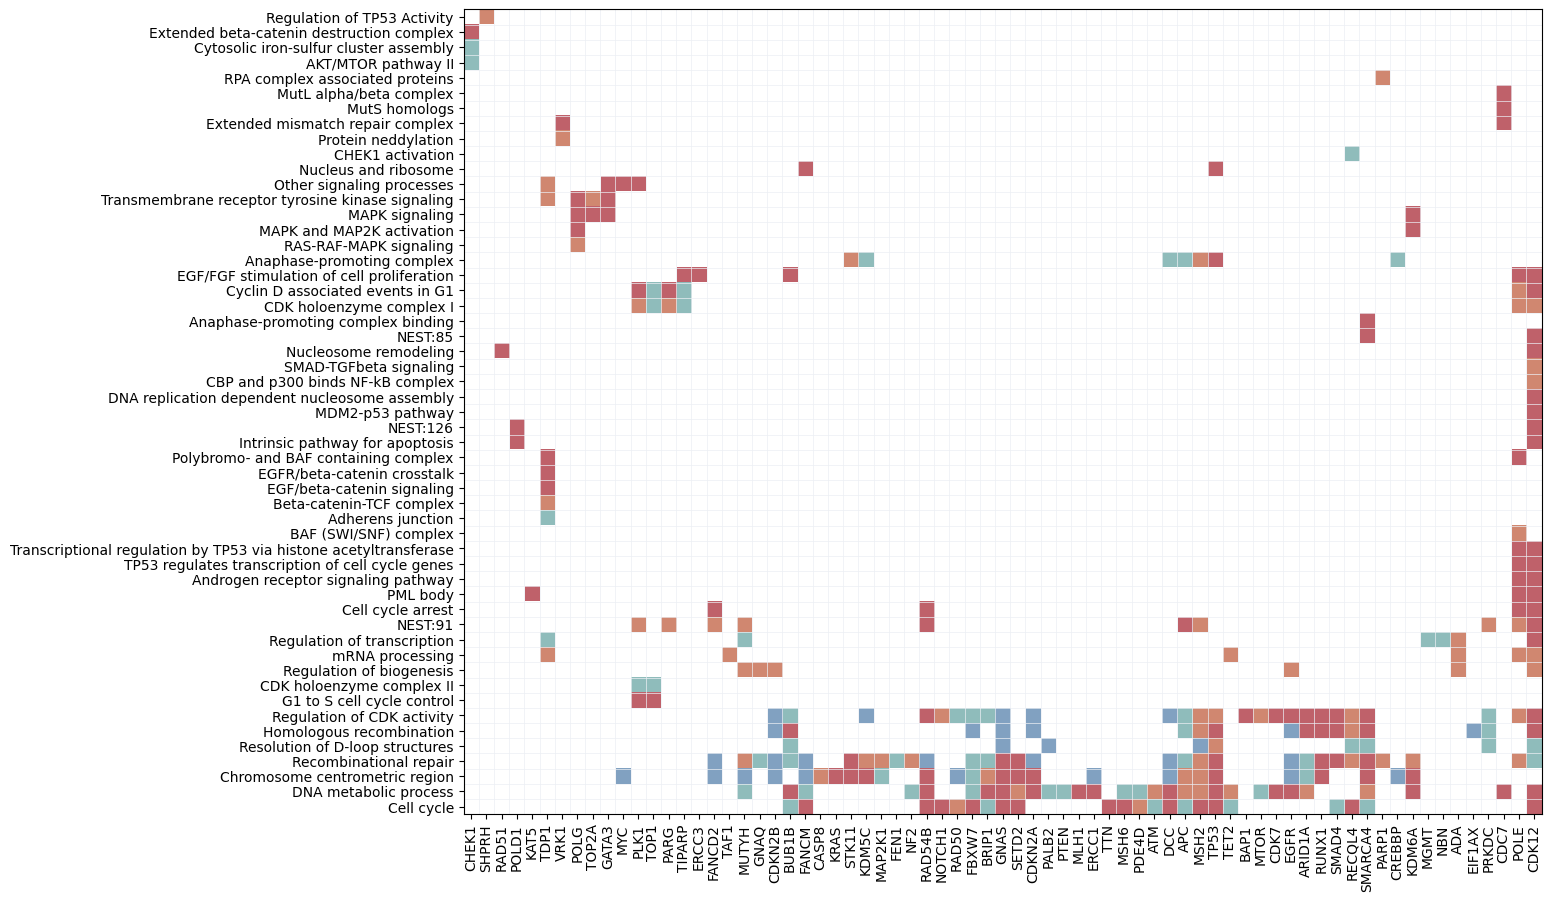

In [25]:
full_heatmap, classes_map = map_classes_to_integer(heatmap)
cmap = get_cmap_from_classes_map(classes_map)

row_index, col_index = cluster_order(full_heatmap, metric="correlation")

split_heatmap = SplitHeatmap(
    dataframe=full_heatmap,
    row_indices=[row_index],
    col_indices=[col_index],
    horizontal_gap=0.1,
    cmap=cmap,
)

split_heatmap.convert_to_rgb()
split_heatmap.plot(fig_width=14)
split_heatmap.add_bottom_xticklabels(rotation=90)
split_heatmap.add_yticklabels()
split_heatmap.add_grid(color="#eceff4", linewidth=0.5)
